# Introduction

This notebook will walkthrough the exploratory data analysis from the dataset made. Input features are HRRR and targets come from RWIS sites.

In [2]:
# standard python imports
import numpy as np
import pandas as pd
import os
import sys
import joblib
import itertools

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# custom classes to handle data processing
from ProbSR.ml_lib.core.sample_methods import SampleTechniques
from ProbSR.ml_lib.utils.utils_funcs import removePredictor

# config file for the project
import ProbSR.scripts.probsr_ml_config as config


In [3]:
#various definitions
target_column = config.TARGET_COLUMN

#get the predictor columns
cols_to_use = config.PREDICTOR_COLUMNS

#get the column dtypes
hrrr_dtypes = config.COLUMN_DTYPES

In [18]:
def comparison_hist(df_in, columns_to_plot):
    
    ''' Histogram of the continous predictor columns in our dataframe
    Inputs:
        df_in (pd.DataFrame) : data to plot
        columns_to_plot (list) : list of columns names (strings) to plot
    '''
    
    fig, ax = plt.subplots(5,5,figsize=(24,18))
    plt.subplots_adjust(wspace=0.5, hspace=0.75)
    
    # separate ones, zeros data
    ones_data  = df_in[df_in[target_column] > 0]
    zeros_data = df_in[df_in[target_column] < 1]
    
    first_col = True
    for col, subax in zip(columns_to_plot, ax.flatten()):

        data_1 = ones_data.loc[:,col].to_numpy()
        data_0 = zeros_data.loc[:,col].to_numpy()
        
        # plot!
        subax.hist(data_0, bins=20, alpha=0.5,
                   edgecolor='k', color='xkcd:water blue', label='above frez.')
        subax.hist(data_1, bins=20, alpha=0.5,
                   edgecolor='k', color='xkcd:fire engine red', label='sub frez.')
        
        # despine
        subax.spines['right'].set_visible(False)
        subax.spines['top'].set_visible(False)
        subax.spines['left'].set_visible(False)
        
        # add predictor as title
        subax.set_title(col)
        
        # only show legend for first plot
        if first_col is True:
            subax.legend(loc='upper right')
            first_col = False
            
    return fig, ax

In [19]:
def comparison_boxplot(df_in, columns_to_plot):
    
    ''' Boxplot of the continous predictor columns in our dataframe.
        Inputs:
        df_in (pd.DataFrame) : data to plot
        columns_to_plot (list) : list of columns names (strings) to plot
    '''
    
    labels = ['above frez.', 'subfrez']
    colors = ['xkcd:water blue', 'xkcd:fire engine red']
    
    fig, ax = plt.subplots(5,5,figsize=(24,18))
    plt.subplots_adjust(wspace=0.5, hspace=0.75)
    
    ones_data  = df_in[df_in[target_column] > 0]
    zeros_data = df_in[df_in[target_column] < 1]
    
    first_col = True
    for col, subax in zip(cols, ax.flatten()):

        data_1 = ones_data.loc[:,col].to_numpy()
        data_0 = zeros_data.loc[:,col].to_numpy()
        
        box_data = [data_0, data_1]
        bplot = subax.boxplot(box_data, 
                              notch=False, 
                              sym='', 
                              patch_artist=True,
                              labels=labels)
        
        # add colors
        for patch, color in zip(bplot['boxes'], colors):
            patch.set_facecolor(color)
        
        # Despine
        subax.spines['right'].set_visible(False)
        subax.spines['top'].set_visible(False)
        subax.spines['left'].set_visible(False)
        
        subax.set_title(col)
            
    return fig, ax

In [22]:
def plot_sample_scatter_plots(df_in, list_of_columns):
    
    ''' Scatter plots of continous predictor columns in our dataframe.
        Inputs:
        df_in (pd.DataFrame) : data to plot
        columns_to_plot (list) : list of columns names (strings) to plot
    '''
        
    fig, ax = plt.subplots(5,5,figsize=(24,18))
    plt.subplots_adjust(wspace=0.5, hspace=0.75)
    
    ones_data  = df_in[df_in[target_column] > 0]
    zeros_data = df_in[df_in[target_column] < 1]
    
    first_col = True
    for col_pair, subax in zip(list_of_columns, ax.flatten()):

        pred1_af = zeros_data[col_pair[0]]
        pred2_af = zeros_data[col_pair[1]]
 
        pred1_bf = ones_data[col_pair[0]]
        pred2_bf = ones_data[col_pair[1]]
        
        subax.scatter(pred1_af, pred2_af, s=5, color='xkcd:water blue', label='above frez.')
        subax.scatter(pred1_bf, pred2_bf, s=5, color='xkcd:fire engine red', label='subfrez')
        subax.set_xlabel(col_pair[0])
        subax.set_ylabel(col_pair[1])

        # Despine
        subax.spines['right'].set_visible(False)
        subax.spines['top'].set_visible(False)
        subax.spines['left'].set_visible(False)
        
        #subax.set_title(col)
        
        if first_col is True:
            subax.legend(loc='upper right')
            first_col = False
            
    return fig, ax

In [7]:
def preprocess(data0):

    '''Very basic preprocessing to the dataset after we read it in.'''
    
    # convert units of brightness temp to C from K
    if ('sat_irbt' in data0.columns):
        data0['sat_irbt'] -= 273.15

    # drop non-necessary columns if in DataFrame
    cols_to_drop = ['prev_RT', 'obs_subsfc_rt', 'precip', 'veg_type', 'time_day',
                    'Unnamed: 0.1.1', 'Unnamed: 0.1', 'Unnamed: 0']

    for column in cols_to_drop:
        if (column in data0.columns):
            data0, _ = removePredictor(data0, column, 1)

    # drop September
    data0 = data0[data0['month'] != 9]
    data0 = data0.reset_index(drop=True, inplace=False)

    # compute difference in soilT between 2 top layers
    data0['soilT_diff'] = data0['soilT_0_01m'] - data0['soilT_0_1m']
    
    # add was_precipitating field to be based on 1-hr accumulated precip (1HRAD; from MRMS)
    data0['was_precipitating'] = 0
    iprecip = np.where(data0['1HRAD'] > 0.0)[0]
    data0.loc[iprecip, 'was_precipitating'] = 1
    data0['was_precipitating'].astype('int')
    
    # drop rows with nans
    data0 = data0.dropna(axis=0, how='any')
    data0 = data0.reset_index(drop=True, inplace=False)

    # make sure target variable is of type int
    data0[target_column].astype('int')
    
    return data0


# Load in our data
After preprocessing data (not describeed here), the total size of the data collected (3 years worth) consists of ~8 million rows (examples) with 58 columns totalling close to 5 GB of data. For simplicity, we will explore the training data only, which is considered the 2016-17 winter season. This dataset contains ~2.8 million examples to begin with. If we wanted to explore the entire dataset, we could read it all into memory at once (5 GB isn't a huge amount for a standar laptop these days), or we can specify column datatypes/read in specific columns only to reduce memory consumption.

In [9]:
# read in the dataset considered for training
data = pd.read_csv(config.TRAINING_DATA_PATH)
print(data.shape)
print(data.columns)

# also, perform subtle preprocessing (i.e. nan removal, etc)
data = preprocess(data)

(2890805, 45)
Index(['Unnamed: 0', 'lon', 'lat', 'sfc_temp', 'temp2m', 'dwpt2m', 'wind10m',
       'sfc_rough', 'fric_vel', 'sens_hf', 'lat_hf', 'gflux', 'swave_flux',
       'dllwave_flux', 'uplwav_flux', 'sat_irbt', 'low_cloud', 'mid_cloud',
       'high_cloud', 'tot_cloud', 'vbd_flux', 'vdd_flux', 'snow_cover',
       'soilT_0_01m', 'soilT_0_1m', 'PRECIPRATE', '1HRAD', '3HRAD', 'date',
       'obs_rt', 'cat_rt', 'RWIS_site', 'tmp2m_hrs_bl_frez',
       'sfcT_hrs_bl_frez', 'tmp2m_hrs_ab_frez', 'sfcT_hrs_ab_frez',
       'date_marker', 'urban', 'rural', 'was_precipitating', 'month',
       'd_ground', 'd_rad_d', 'd_rad_u', 'hrrr_dT'],
      dtype='object')


In [10]:
# let's list some memory information
print(f"This dataset takes up {data.memory_usage(deep=True).sum()/1E9} GB of RAM")

This dataset takes up 1.352197329 GB of RAM


In [11]:
# what's the event frequency?
print(f"Event frequency of subfreezing road temps is: {data[target_column].mean()}")

Event frequency of subfreezing road temps is: 0.2315253380792303


In [39]:
# make a copy of the big dataframe with only the columns we care about for prediction
predictor_matrix = data.copy()

# compute the correlation matrix
corr_matrix = predictor_matrix.corr(method='spearman')
np.fill_diagonal(corr_matrix.values, 0.0)

In [40]:
def plot_correlation_matrix(corr_matrix):
    '''Plots the correlation matrix
    Inputs: corr_matrix (np.ndarray) : a correlation matrix'''
    
    fig, ax = plt.subplots(figsize=(24, 18))

    ax = sns.heatmap(corr_matrix, 
                     vmin=-1, vmax=1, center=0, annot=True,
                     cmap=sns.diverging_palette(20, 220, n=200), square=True
    )

    ticks = np.arange(corr_matrix.shape[0]) + 0.5
    ax.set_xticks(ticks)
    ax.set_xticklabels(corr_matrix.columns, rotation=90, fontsize=8)
    ax.set_yticks(ticks)
    ax.set_yticklabels(corr_matrix.index, rotation=360, fontsize=8)

    ax.set_title('correlation matrix')
    plt.tight_layout()

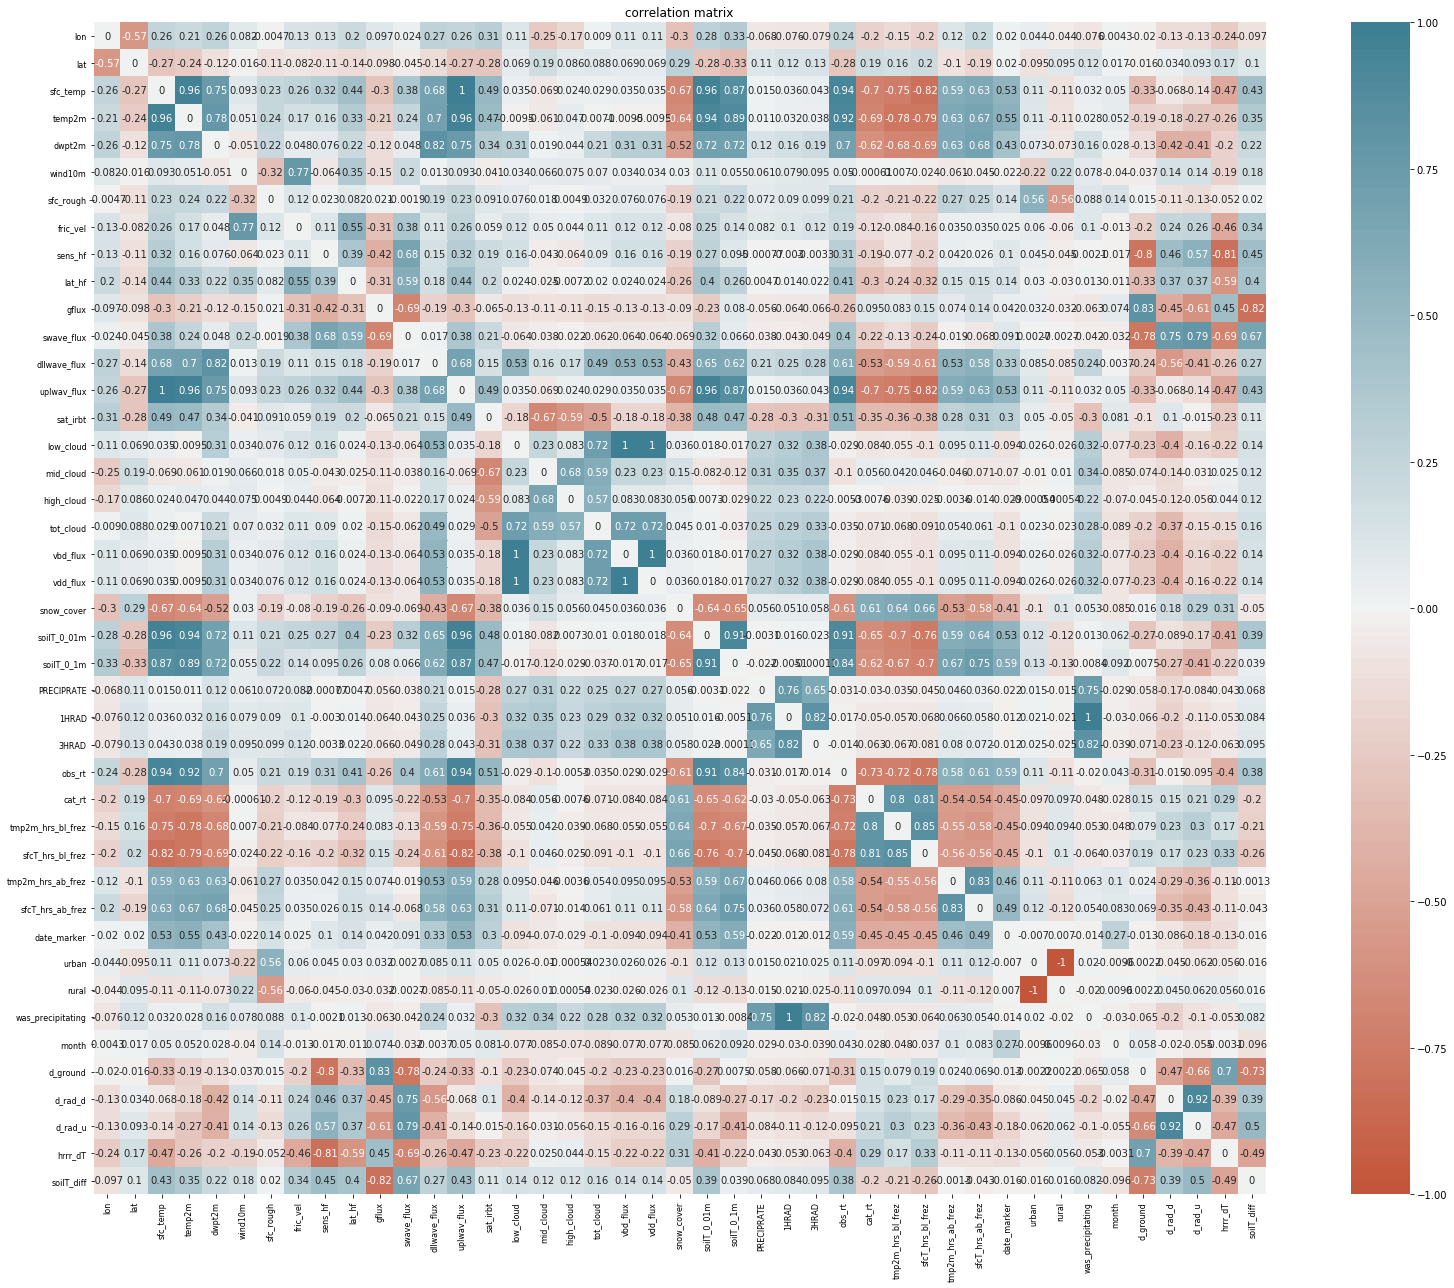

In [41]:
# plot the correlation matrix
plot_correlation_matrix(corr_matrix)

In [ ]:
# find feature correlations with the observed road temperature > 0.5 or < -0.5
filter = corr_matrix['obs_rt'].abs() > 0.5
print(corr_matrix['obs_rt'][filter])

The most correlated variables make intuitive sense; surface temperature and 2-m air temperature should correlate well with the measured road temperature (obs_rt). Also, some radiation fields have moderate-to-high correlation as well.

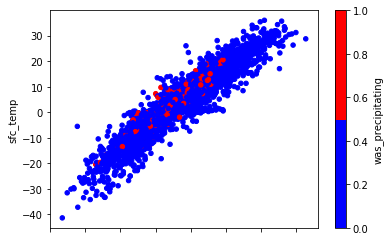

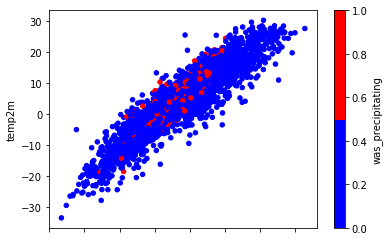

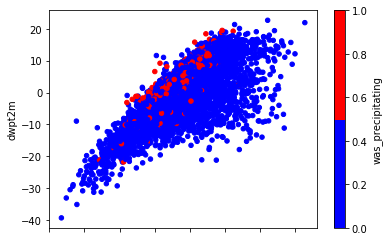

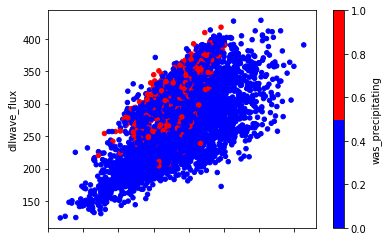

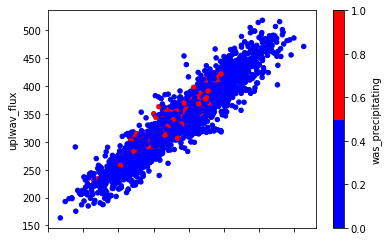

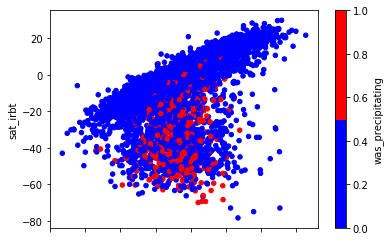

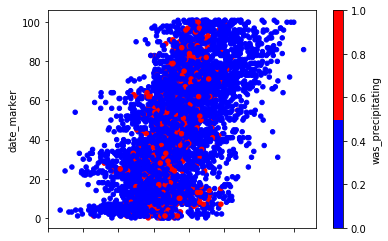

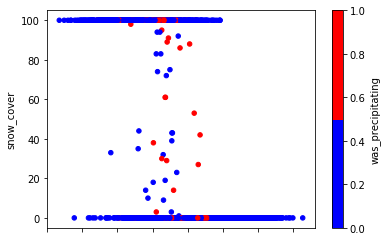

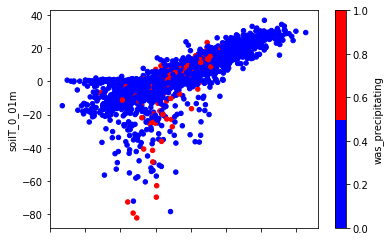

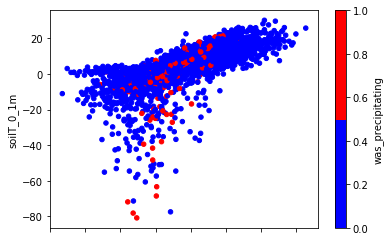

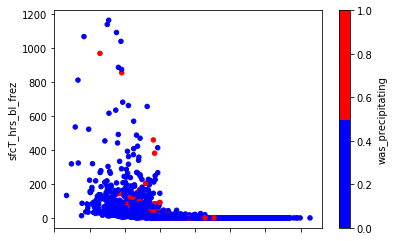

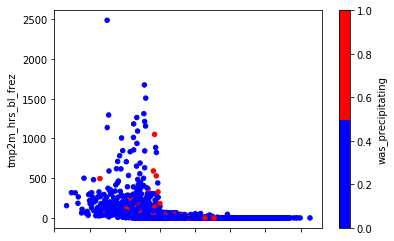

In [61]:
# we can plot sample scatter plots of these fields as well
correlated_predictors = ['sfc_temp','temp2m','dwpt2m','dllwave_flux','uplwav_flux','sat_irbt', 'date_marker',
                         'snow_cover','soilT_0_01m','soilT_0_1m','sfcT_hrs_bl_frez', 'tmp2m_hrs_bl_frez']
predictor_pairs = [('obs_rt', var) for var in correlated_predictors] 

# gather a small sample of data to plot
sample_of_data = data.sample(n=5000, replace=False, random_state=42)
sample_of_data.reset_index(drop=True, inplace=False)
      
for col, subax in zip(correlated_predictors, ax.flatten()):
    subax = sample_of_data.plot.scatter(x='obs_rt', y=col, c='was_precipitating',
                                        colormap=matplotlib.colors.ListedColormap(['blue','red']))

(<Figure size 1728x1296 with 25 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a63783320>,
       dtype=object))

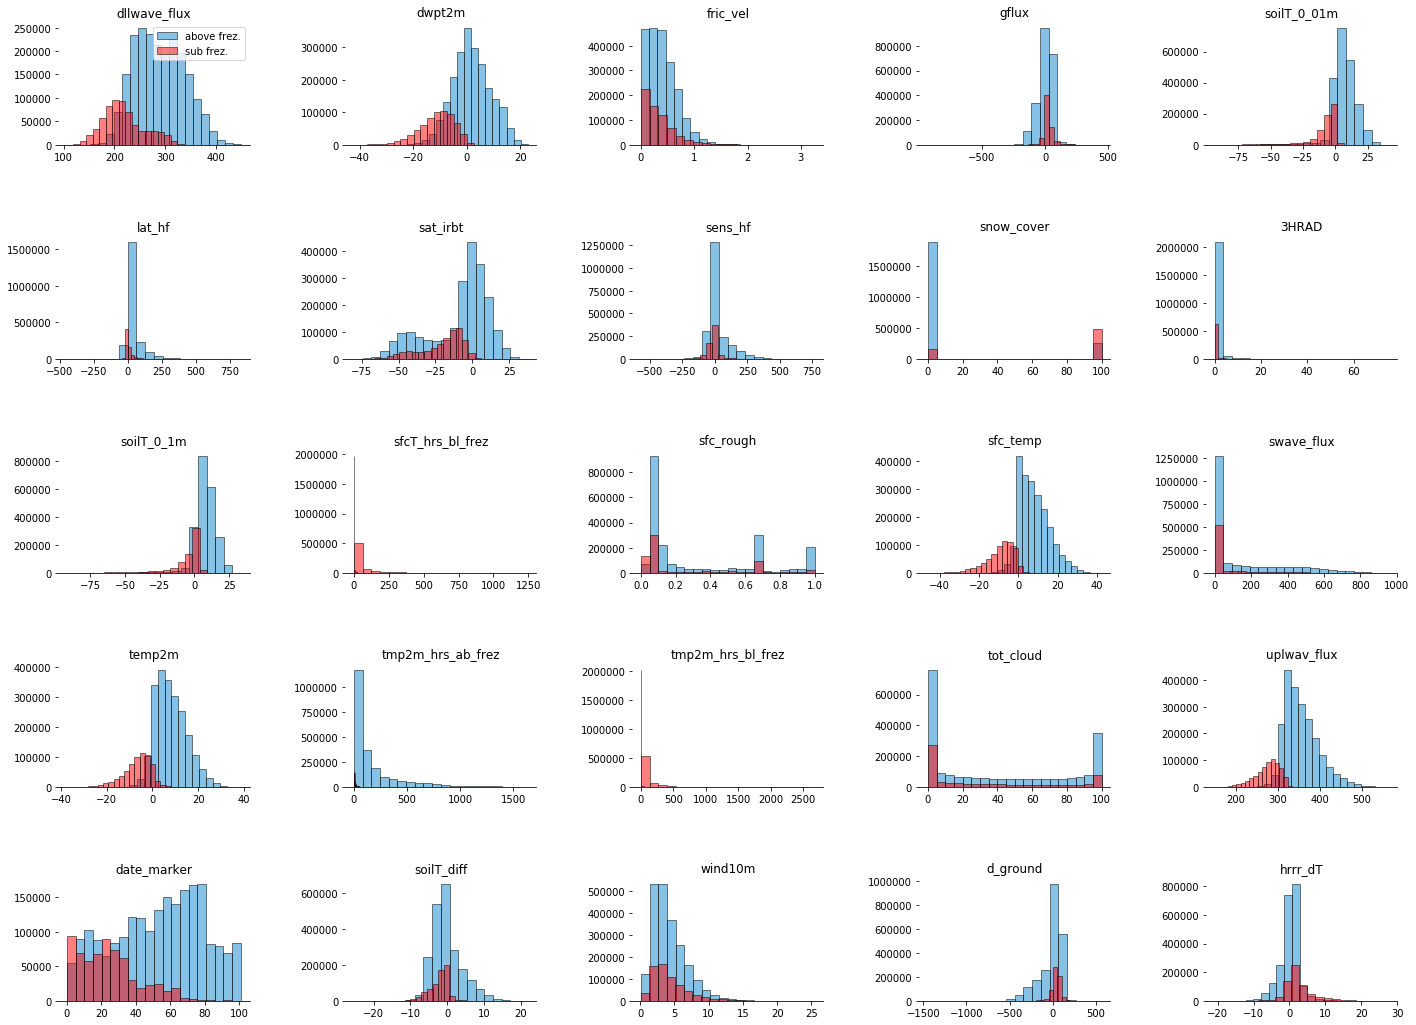

In [56]:
# plot histograms of some features color-coded by the target column
cols = ['dllwave_flux', 'dwpt2m', 'fric_vel', 'gflux', 'soilT_0_01m',
        'lat_hf', 'sat_irbt', 'sens_hf', 'snow_cover', '3HRAD',
        'soilT_0_1m', 'sfcT_hrs_bl_frez', 'sfc_rough', 'sfc_temp',
        'swave_flux', 'temp2m', 'tmp2m_hrs_ab_frez', 'tmp2m_hrs_bl_frez',
        'tot_cloud', 'uplwav_flux', 'date_marker', 'soilT_diff','wind10m',
        'd_ground', 'hrrr_dT']

comparison_hist(data, cols)


Overall, there are a few predictors that distinguish between above freezing and subfreezing roads. They are:
sfc_temp, temp2m, uplwav_flux, dwpt2m, soilT fields, dlwav_flux, and date marker. However, some of these fields are quite correlated with one another (e.g., sfc_temp and uplwav_flux) so it may be worthwhile to only use some of these features.

# Handling class imbalance problem

We saw that after reading in the dataset that ~25% of the observations are subfreezing. Therefore, class imbalance is an issue we should look into mitigating. Since we are dealing with subfreezing roadways, there are some questions we should ask regarding the problem.

1.) When is it most important to know if a road could be subfreezing? (i.e., are there any other factors)

2.) Are there easy cases we can discard? (i.e., too warm, too cold?)

My answers would be:

1.) We care most when observed air temperatures are close to freezing (0 deg C / 32 deg F). However, we also are concerned when it's precipitating. It would be more useful to have a reliable prediction when it's 30F and snowing as opposed to 20F clear skies.

2.) I would argue if the ambient air temperature is much above or below freezing, the road surface temperature would also be. Maybe we can discard some obvious ranges (i.e., >= 10 C and <= -10 C). Let's see what the data says!

In [40]:
# given a subfreezing (or above subfreezing roadway) what's the typical Tsfc and T2m distribution?
data.groupby('cat_rt')[['sfc_temp','temp2m','soilT_0_1m']].describe(percentiles=[0.01,0.99])

sfc_temp                                                            \
            count      mean       std    min      1%    50%     99%     max   
cat_rt                                                                        
0.0     2156396.0  7.892568  7.653205 -19.78  -6.035  6.700  29.030  42.530   
1.0      649677.0 -9.315250  7.058971 -46.12 -30.140 -7.973   0.833   7.984   

           temp2m            ...                 soilT_0_1m            \
            count      mean  ...     99%     max      count      mean   
cat_rt                       ...                                        
0.0     2156396.0  7.948257  ...  25.340  38.620  2156396.0  7.725080   
1.0      649677.0 -6.790302  ...   3.182   7.992   649677.0 -5.316692   

                                                                     
              std    min         1%       50%        99%        max  
cat_rt                                                               
0.0      7.474000 -89.75 -17.649994  7.450012  23.149994  33.350006  
1.0     11.385165 -91.75 -56.250000 -1.250000   4.750000  14.350006  

[2 rows x 24 columns]

Very few subfreezing roads are witnessed when the air temperature is greater than 5.0 deg C. Also, very few above freezing freezing roads are witnessed when the air temperature is below -8.0 deg C.

In [13]:
# lets make a dataset only with obsrvations between -8 C and +5 C
data_constricted = data[(data['sfc_temp'] > -8.0) & (data['sfc_temp'] < 5.0)]
data_constricted.reset_index(drop=True, inplace=True)
data_constricted.shape


(1207748, 45)

(<Figure size 1728x1296 with 25 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a307b5a58>,
       dtype=object))

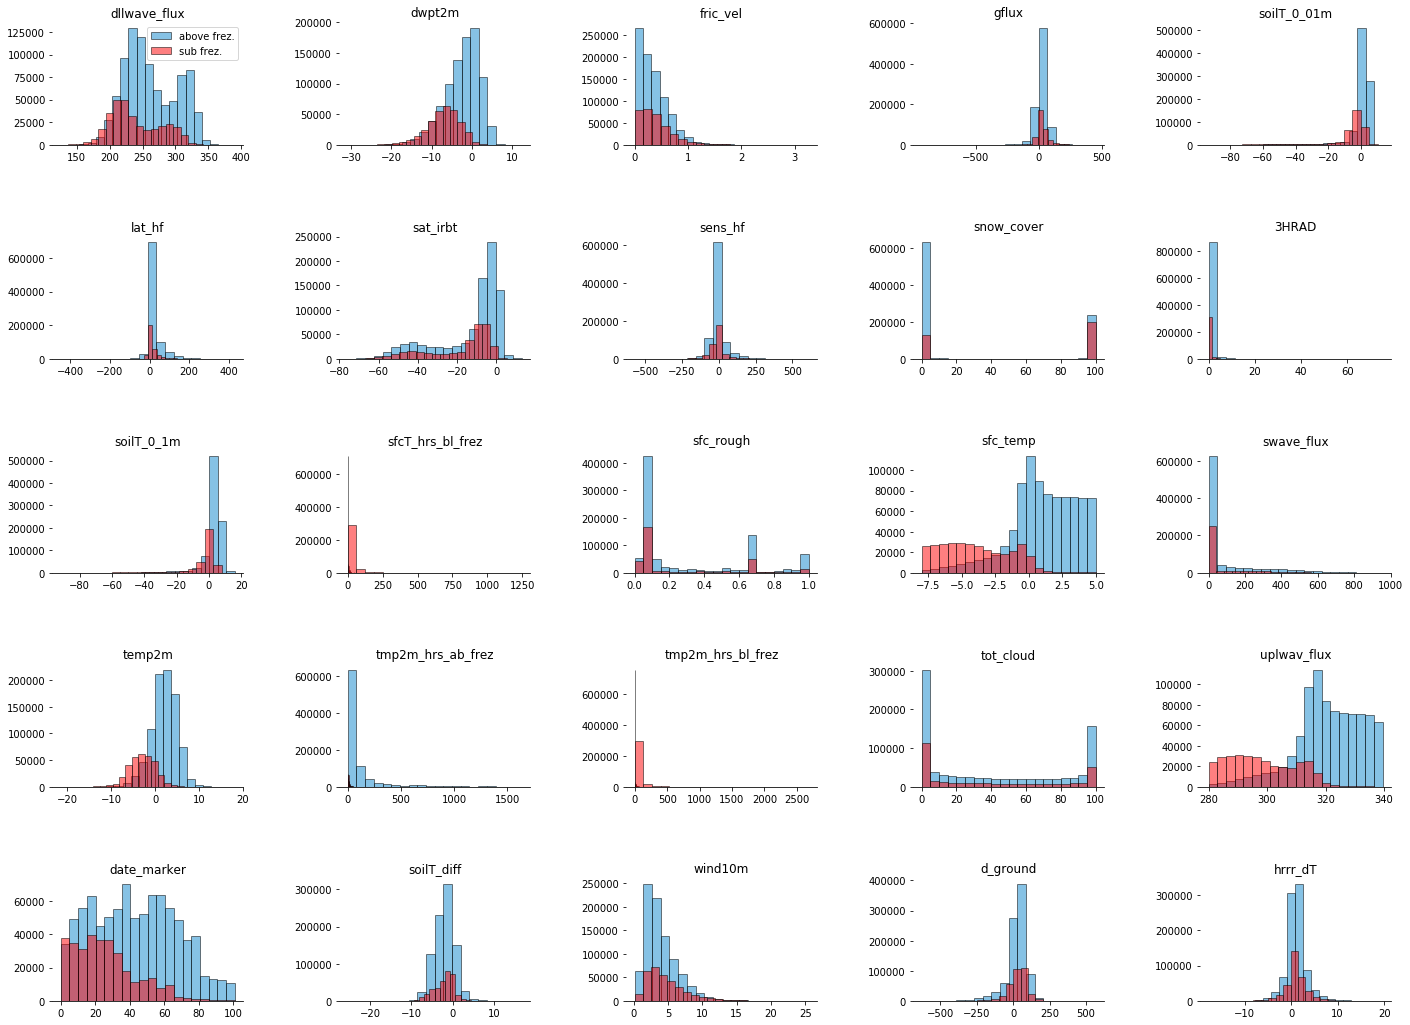

In [14]:
# plot histograms of the smaller dataset we created that doesn't have high values.
cols = ['dllwave_flux', 'dwpt2m', 'fric_vel', 'gflux', 'soilT_0_01m',
        'lat_hf', 'sat_irbt', 'sens_hf', 'snow_cover', '3HRAD',
        'soilT_0_1m', 'sfcT_hrs_bl_frez', 'sfc_rough', 'sfc_temp',
        'swave_flux', 'temp2m', 'tmp2m_hrs_ab_frez', 'tmp2m_hrs_bl_frez',
        'tot_cloud', 'uplwav_flux', 'date_marker', 'soilT_diff','wind10m',
        'd_ground', 'hrrr_dT']

comparison_hist(data_constricted, cols)

In [59]:
# make a copy of the big dataframe with only the columns we care about for prediction
predictor_matrix = data_constricted

# compute the correlation matrix
corr_matrix = predictor_matrix.corr(method='spearman')
np.fill_diagonal(corr_matrix.values, 0.0)

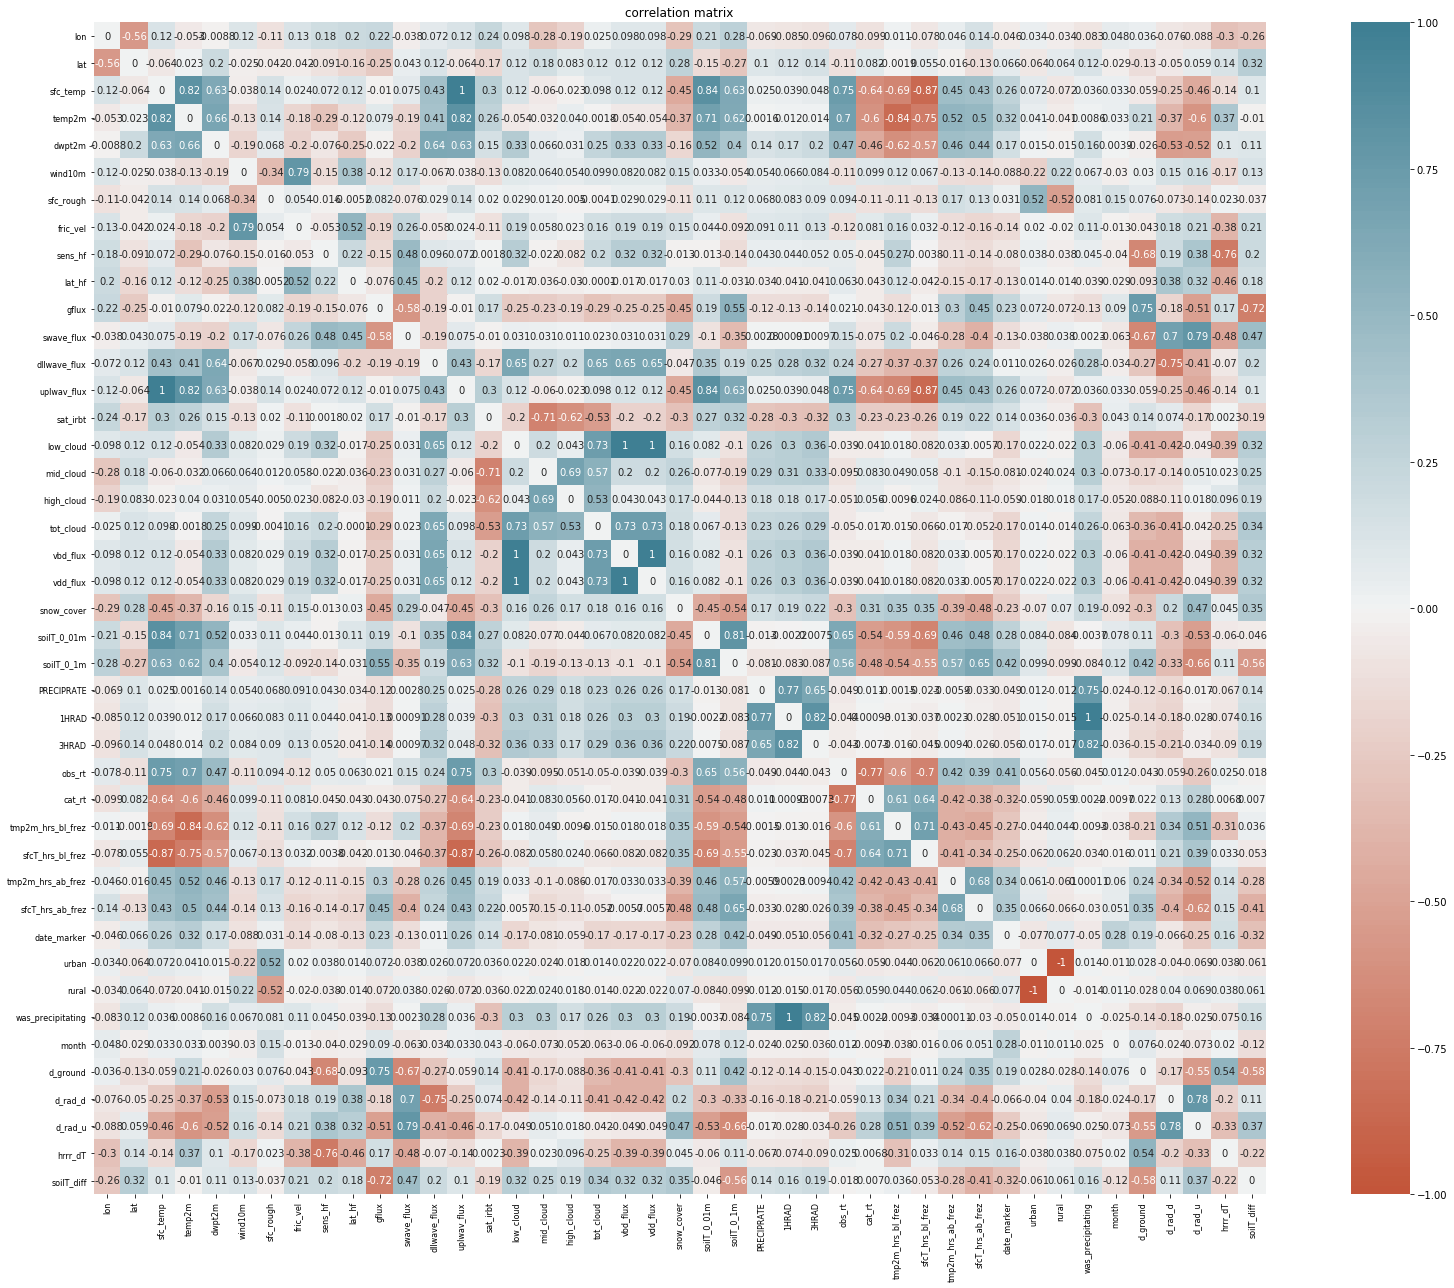

In [63]:
# plot the correlation matrix
plot_correlation_matrix(corr_matrix)

In [65]:
# find feature correlations > 0.5 or < -0.5 with target variable
filter = corr_matrix['cat_rt'].abs() > 0.5
print(corr_matrix['cat_rt'][filter])

sfc_temp            -0.635692
temp2m              -0.602083
uplwav_flux         -0.635682
soilT_0_01m         -0.536498
obs_rt              -0.768362
tmp2m_hrs_bl_frez    0.606214
sfcT_hrs_bl_frez     0.644571
Name: cat_rt, dtype: float64


(<Figure size 1728x1296 with 25 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1f071ef0>,
       dtype=object))

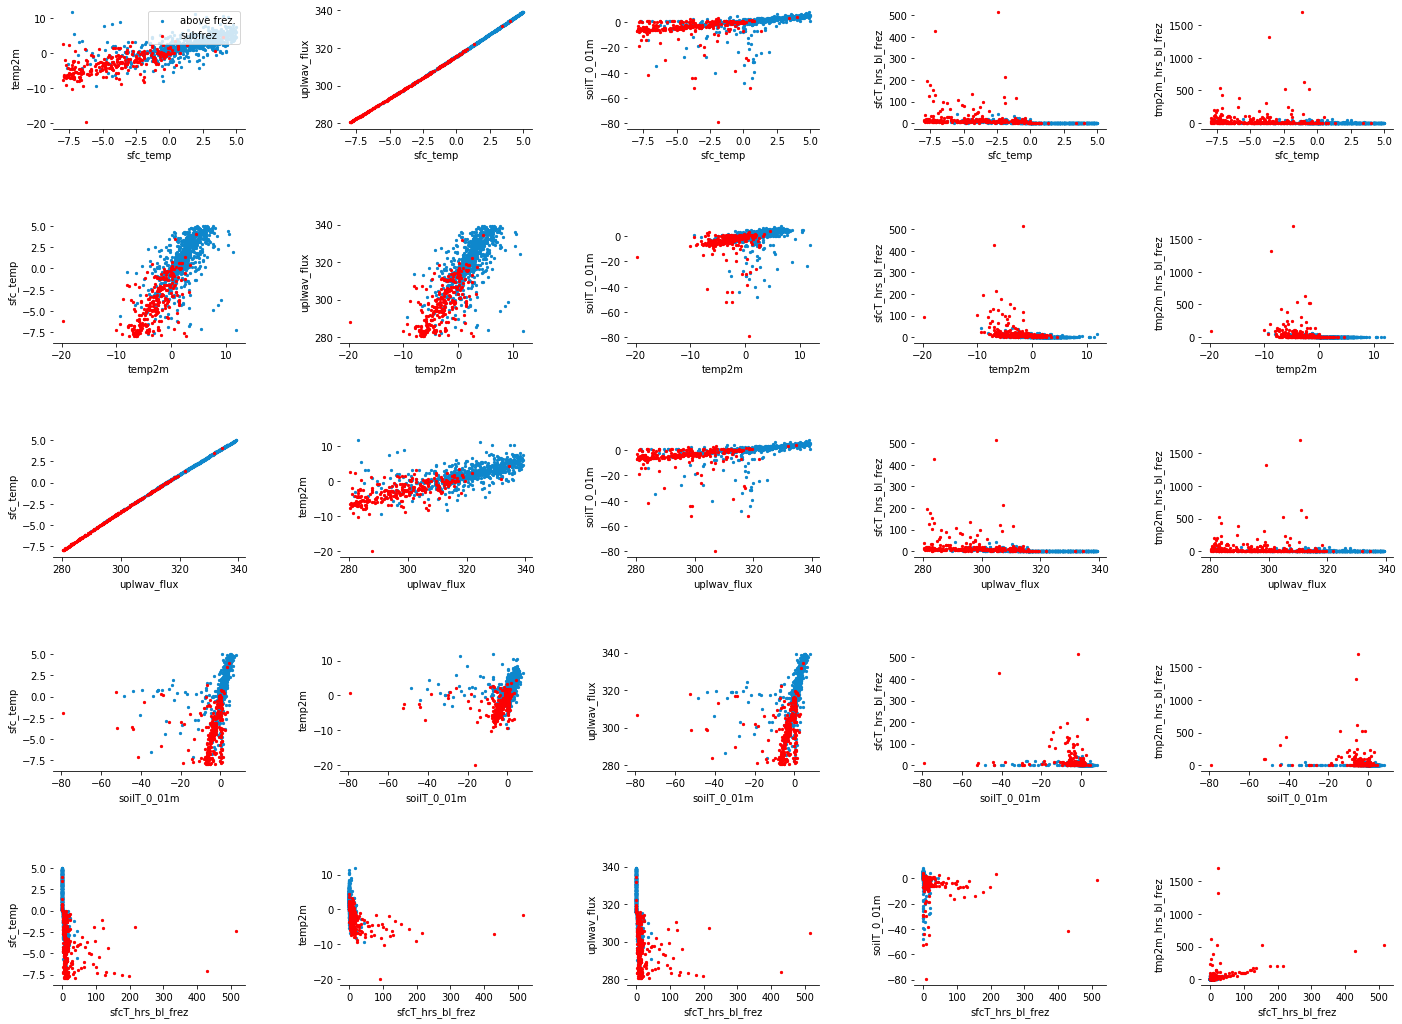

In [24]:
# we can plot sample scatter plots of these fields as well
correlated_predictors = ['sfc_temp','temp2m','uplwav_flux','soilT_0_01m','sfcT_hrs_bl_frez', 'tmp2m_hrs_bl_frez']
predictor_pairs = itertools.permutations(correlated_predictors, 2)  

# gather a small sample of data to plot
sample_of_data = data_constricted.sample(n=1000, replace=False, random_state=42)
sample_of_data.reset_index(drop=True, inplace=False)
plot_sample_scatter_plots(sample_of_data, predictor_pairs)

Based on these sample scatterplots, upward longwave flux (uplwav_flux) and the surface temperature (sfc_temp) look almost identical. Most likely, the upward longwave flux uses the surface temperature in it's calculation. Thus, we will drop the uplwav_flux variable to limit redundant information.

# Precipitation Impacts

In [56]:
# get counts of when it was precipitating
print(data_constricted['was_precipitating'].value_counts())
print(f"Fraction of total observations classified as precipitating {data_constricted['was_precipitating'].mean()}")

0    1072935
1     134813
Name: was_precipitating, dtype: int64
Fraction of total observations classified as precipitating 0.11162345124976403


In [55]:
# split dataset into precip and non-precip datasets
data_precip = data_constricted[data_constricted['was_precipitating'] > 0]
data_notprecip = data_constricted[data_constricted['was_precipitating'] < 1]
print(data_precip.shape, data_notprecip.shape)

(134813, 45) (1072935, 45)


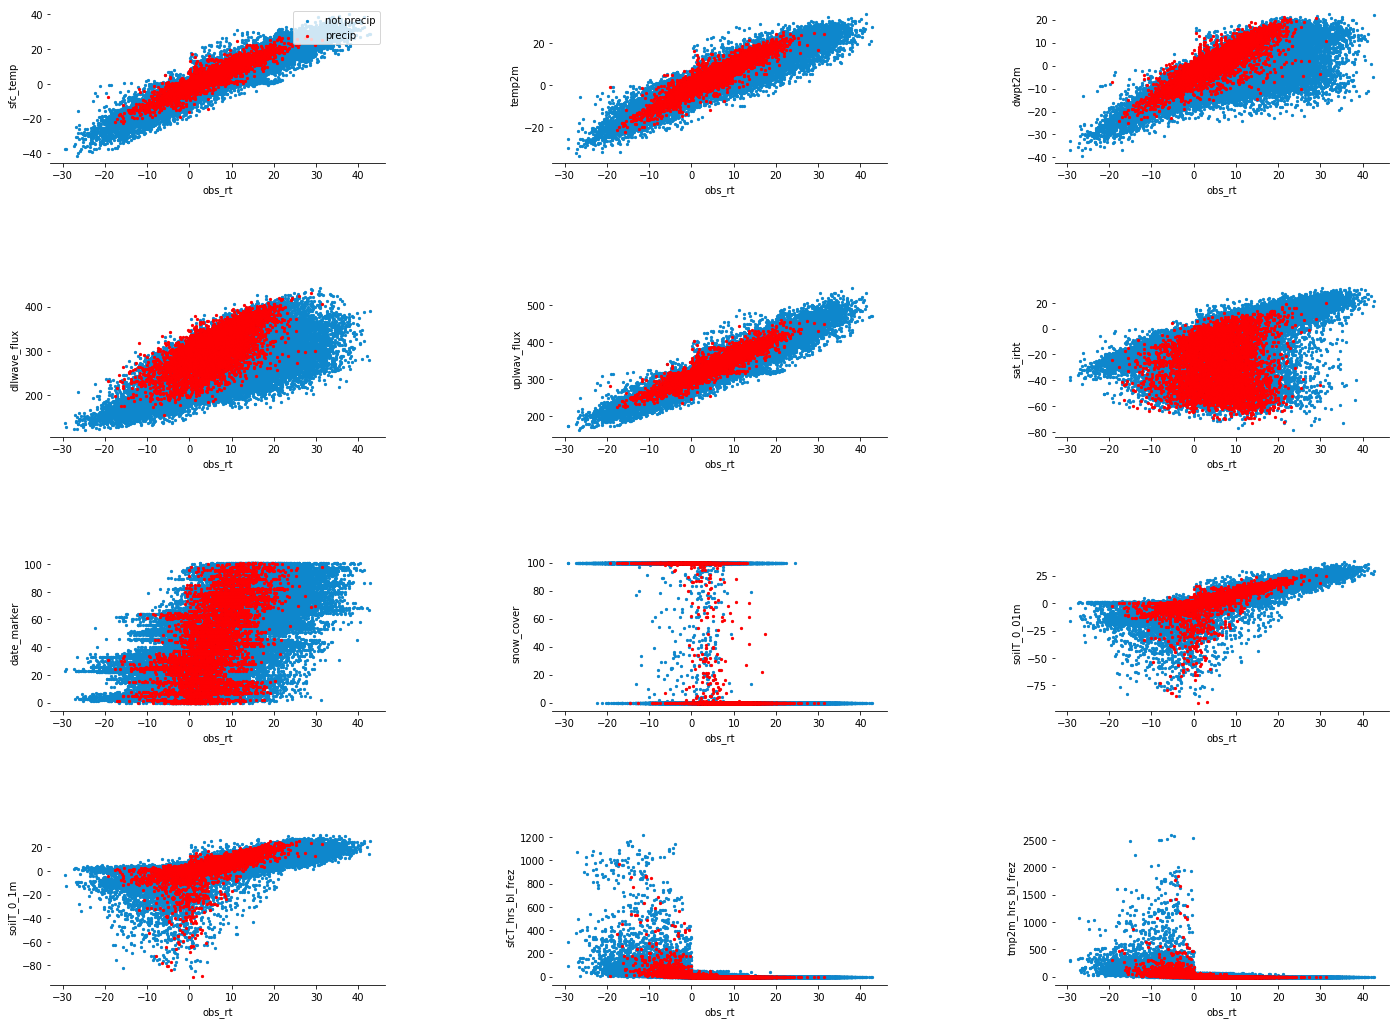

In [120]:
# gather a small sample of data to plot
sample_of_data = data.sample(n=50000, replace=False, random_state=42)
sample_of_data.reset_index(drop=True, inplace=False)

fig, ax = plt.subplots(4,3,figsize=(24,18))
plt.subplots_adjust(wspace=0.5, hspace=0.75)

precip_data  = sample_of_data[sample_of_data['was_precipitating'] > 0]
nonprecip_data = sample_of_data[sample_of_data['was_precipitating'] < 1]

first_col = True
for col, subax in zip(correlated_predictors, ax.flatten()):

    subax.scatter(nonprecip_data['obs_rt'], nonprecip_data[col], s=5, color='xkcd:water blue', label='not precip')
    subax.scatter(precip_data['obs_rt'], precip_data[col], s=5, color='xkcd:fire engine red', label='precip')
    subax.set_xlabel('obs_rt')
    subax.set_ylabel(col)

    # Despine
    subax.spines['right'].set_visible(False)
    subax.spines['top'].set_visible(False)
    subax.spines['left'].set_visible(False)

    #subax.set_title(col)

    if first_col is True:
        subax.legend(loc='upper right')
        first_col = False

Roughly 11% of our observations coincide with times when it was precipitating. When examining the scatter plots, some of the features also appear to have different slopes (subjectively). For example, 2-m temperature vs observed road temperatures; the slope looks greate for precipitation observations than compared to non-precipitation observations. 

# Principal Component Analysis

We can try to apply PCA to this dataset, but we already have a good idea as to which features will be important.

Performing PCA...
Explained variance ratio...
[0.1984099  0.16191234 0.10762361 0.0868205  0.07896742 0.06779748
 0.06218618 0.04570251 0.03630026 0.02637387]


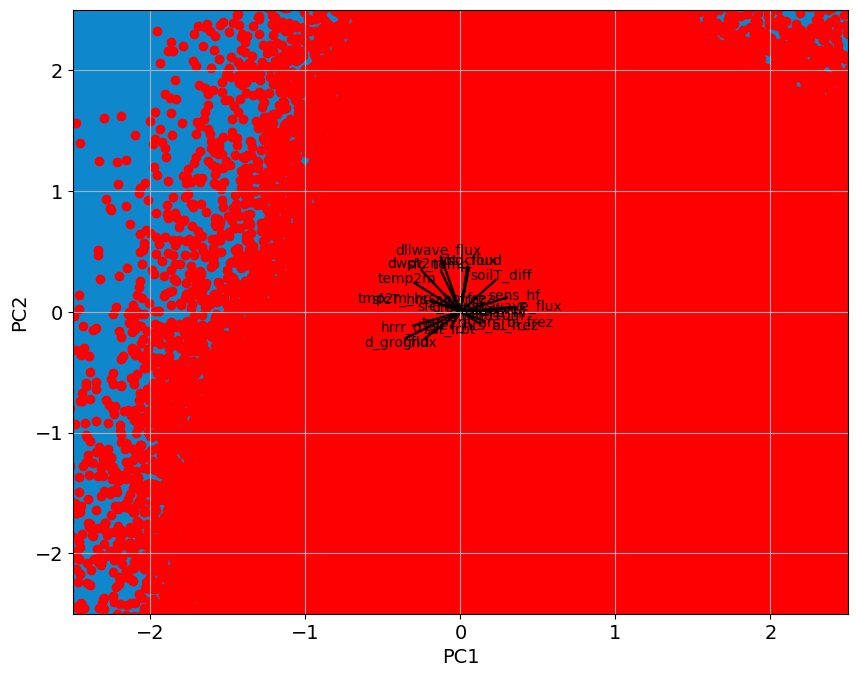

In [38]:
# let's try PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# In general, it's a good idea to scale the data prior to PCA.
scaler = StandardScaler()
X_scaled=scaler.fit(data_constricted[cols_to_use]).transform(data_constricted[cols_to_use]) 

print("Performing PCA...")
pca = PCA(n_components=10, copy=True, random_state=42)
x_pca = pca.fit(X_scaled).transform(X_scaled)

print("Explained variance ratio...")
print(pca.explained_variance_ratio_)

def biplot(score, coeff , y, cols):
    '''
    Author: Serafeim Loukas, serafeim.loukas@epfl.ch
    Inputs:
       score: the projected data
       coeff: the eigenvectors (PCs)
       y: the class labels
   '''
    xs = score[:,0] # projection on PC1
    ys = score[:,1] # projection on PC2
    n = coeff.shape[0] # number of variables
    plt.figure(figsize=(10,8), dpi=100)
    classes = np.unique(y)
    colors = ['xkcd:water blue', 'xkcd:fire engine red']
    markers=['o','o']
    for s,l in enumerate(classes):
        plt.scatter(xs[y==l],ys[y==l], c = colors[s], marker=markers[s]) # color based on group
    for i in range(n):
        #plot as arrows the variable scores (each variable has a score for PC1 and one for PC2)
        plt.arrow(0, 0, coeff[i,0], coeff[i,1], color = 'k', alpha = 0.9,linestyle = '-',linewidth = 1.5, overhang=0.2)
        plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, cols[i], color = 'k', ha = 'center', va = 'center',fontsize=10)

    plt.xlabel("PC{}".format(1), size=14)
    plt.ylabel("PC{}".format(2), size=14)
    limx= int(xs.max()) + 1
    limy= int(ys.max()) + 1
    plt.xlim([-2.5, 2.5])
    plt.ylim([-2.5, 2.5])
    plt.grid()
    plt.tick_params(axis='both', which='both', labelsize=14)

#Call the function. Use only the 2 PCs.
biplot(x_pca[:,0:2],np.transpose(pca.components_[0:2, :]), data_constricted[target_column], cols_to_use)
plt.show()